### Import packages

In [1]:
import folium
import functools
import geopandas as gpd
import io
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from opentnsim import core
from opentnsim import lock
from opentnsim import model
from opentnsim import output
from opentnsim import vessel as _vessel
from opentnsim import vessel_traffic_service
import os
import pandas as pd
import pickle
import pyproj
import requests
from shapely.geometry import Point,LineString,Polygon
from shapely.geometry.collection import GeometryCollection
from shapely.ops import transform, linemerge, split, snap
import simpy
import yaml

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# Basic lock simulation
Remember the exercise on the capacity of a lock that was given by Arne van der Hout? Instead of calculating the lock capacity by hand, we can actually simulate locks using the software of OpenTNSim. How does this work?

First, we create an environment

In [2]:
env = simpy.Environment()

#Also we need to add a time
env.simulation_start = pd.Timestamp('2024-01-01')

We need to create a graph and add to the environment

In [3]:
#We need to create a network over which the vessels will sail
FG = nx.DiGraph()
FG.add_node('A',geometry=Point(0,0))
FG.add_node('B',geometry=Point(0,400))
FG.add_node('C',geometry=Point(0,800))
FG.add_edge('A','B',geometry=LineString([Point(0,0),Point(0,400)]),Info={'length':400})
FG.add_edge('B','A',geometry=LineString([Point(0,400),Point(0,0)]),Info={'length':400})
FG.add_edge('B','C',geometry=LineString([Point(0,400),Point(0,800)]),Info={'length':400})
FG.add_edge('C','B',geometry=LineString([Point(0,800),Point(0,400)]),Info={'length':400})
env.FG = FG
env.FG = nx.MultiDiGraph(env.FG)

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service.VesselTrafficService()

Now we need to create the lock infrastructure

In [4]:
#We can now add infrastructure to the network
lock_chamber_I = lock.IsLock(env=env,
                             name='Lock I',
                             node_doors1 = 'A',
                             node_doors2 = 'B',
                             lock_length = 120,
                             lock_width = 18,
                             lock_depth = 6,
                             distance_doors1_from_first_waiting_area=140,
                             distance_doors2_from_second_waiting_area=0,
                             detector_nodes=['A','B'],
                             levelling_time=1500)

lock.IsLockLineUpArea(env=env,
                      name='Lock I',
                      start_node = 'A',
                      end_node = 'B',
                      lineup_length = 120,
                      distance_to_lock_doors=20)

lock.IsLockLineUpArea(env=env,
                      name='Lock I',
                      start_node = 'B',
                      end_node = 'A',
                      lineup_length = 0,
                      effective_lineup_length = 120,
                      distance_to_lock_doors=0)

waiting_area_lock_Ia = lock.IsLockWaitingArea(env=env,
                                              name='Lock I',
                                              node='A',
                                              distance_from_node=140);

lock.IsLockWaitingArea(env=env,
                       name='Lock I',
                       node='B',
                       distance_from_node=0);

In [5]:
#We can now add infrastructure to the network
lock_chamber_II = lock.IsLock(env=env,
                              name='Lock II',
                              node_doors1 = 'B',
                              node_doors2 = 'C',
                              lock_length = 120,
                              lock_width = 18,
                              lock_depth = 6,
                              distance_doors1_from_first_waiting_area=0,
                              distance_doors2_from_second_waiting_area=140,
                              detector_nodes=['B','C'],
                              levelling_time=1500,
                              node_open='B')

lock.IsLockLineUpArea(env=env,
                      name='Lock II',
                      start_node = 'B',
                      end_node = 'C',
                      lineup_length = 0,
                      effective_lineup_length = 120,
                      distance_to_lock_doors=0)

lock.IsLockLineUpArea(env=env,
                      name='Lock II',
                      start_node = 'C',
                      end_node = 'B',
                      lineup_length = 120,
                      distance_to_lock_doors=20)

lock.IsLockWaitingArea(env=env,
                       name='Lock II',
                       node='B',
                       distance_from_node=0)

waiting_area_lockIIb = lock.IsLockWaitingArea(env=env,
                                              name='Lock II',
                                              node='C',
                                              distance_from_node=140);

Now we need to add a vessel

In [6]:
#We create a type element that schematisizes a vessel
Vessel = type('Vessel',(core.SimpyObject, #It should be a simpy element
                        core.Identifiable, #The vessel should be identifiable
                        lock.HasLock, #The vessel should interact with a lock chamber
                        lock.HasWaitingArea, #The vessel should interact with a waiting area
                        lock.HasLineUpArea, #The vessel should interact with a line-up area
                        _vessel.VesselProperties, #The vessel should have properties
                        _vessel.ExtraMetadata, #The vessel can have extra metadata
                        output.HasOutput),{}) #The vessel should have output

#Using the element, we need to give the following information to the vessel
vessel = Vessel(env=env,name='Vessel', 
                geometry=Point(0,0),
                origin='A',
                destination='C',
                route=nx.dijkstra_path(FG,'A','C'),
                type='inland vessel',
                L=100,
                B=15,
                T=5,
                H=4,
                v=4,
                arrival_time=pd.Timestamp('2024-01-01'),)

We can now create a process in the environment in which the vessel will move (from node A to node B)

In [7]:
env.process(vessel.move())

<Process(move) object at 0x205fa3bff70>

Run the simulation

In [8]:
env.run()

We can now analyse the logbook of the vessel

In [9]:
vessel_df = pd.DataFrame(vessel.log)
vessel_df

,Time,Location,Action,Status
0,1970-01-01 01:00:00.000000,POINT (0 0),Sailing from node A to node B start,"{'origin': 'A', 'destination': 'C', 'route': [..."
1,1970-01-01 01:00:00.000000,POINT (0 0),Sailing to start of line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
2,1970-01-01 01:00:35.000000,POINT (0 140),Sailing to start of line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
3,1970-01-01 01:00:35.000000,POINT (0 140),Sailing to position in line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
4,1970-01-01 01:00:58.333333,POINT (0 210),Sailing to position in line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
5,1970-01-01 01:00:58.333333,POINT (0 210),Waiting in line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
6,1970-01-01 01:25:00.000000,POINT (0 210),Waiting in line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
7,1970-01-01 01:25:00.000000,POINT (0 210),Sailing to end of line-up area start,"{'origin': 'A', 'destination': 'C', 'route': [..."
8,1970-01-01 01:25:55.555556,POINT (0 260),Sailing to end of line-up area stop,"{'origin': 'A', 'destination': 'C', 'route': [..."
9,1970-01-01 01:25:55.555556,POINT (0 260),Sailing to first set of lock doors start,"{'origin': 'A', 'destination': 'C', 'route': [..."


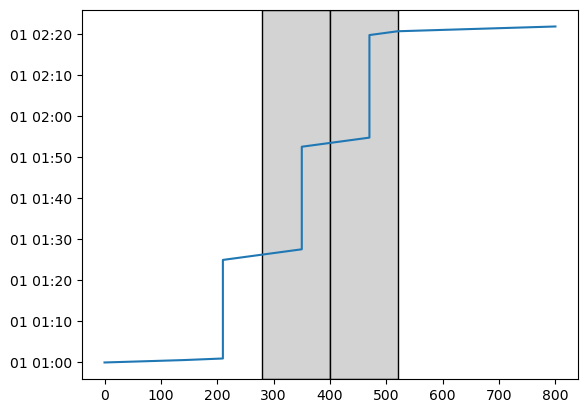

In [12]:
fig,ax = plt.subplots()
ax.plot([point.y for point in vessel_df.Location],vessel_df.Time)
ylim_min,ylim_max = ax.get_ylim()
plt.fill([lock_chamber_I.distance_doors1_from_first_waiting_area+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+lock_chamber_I.lock_length+waiting_area_lock_Ia.distance_from_node,
          lock_chamber_I.distance_doors1_from_first_waiting_area+lock_chamber_I.lock_length+waiting_area_lock_Ia.distance_from_node,],
          [ylim_min,ylim_max,ylim_max,ylim_min],color='lightgrey',edgecolor='k')

length_lock_complex_I = FG.edges['A','B']['Info']['length']
plt.fill([lock_chamber_II.distance_doors1_from_first_waiting_area+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+lock_chamber_II.lock_length+length_lock_complex_I,
          lock_chamber_II.distance_doors1_from_first_waiting_area+lock_chamber_II.lock_length+length_lock_complex_I,],
          [ylim_min,ylim_max,ylim_max,ylim_min],color='lightgrey',edgecolor='k')


ax.set_ylim(ylim_min,ylim_max);

And we can analyse the logbook of the lock

In [11]:
lock_df = pd.DataFrame(lock_chamber2.log)
lock_df

NameError: name 'lock_chamber2' is not defined

In [ ]:
break

### Import FIS-network
##### Load import function

In [ ]:
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network (vaarweginformatie.nl)"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = yaml.load(stream, Loader=yaml.Loader)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
    
    return G

##### Import network

In [ ]:
url = 'https://zenodo.org/record/4578289/files/network_digital_twin_v0.2.yaml'

# create a cached version to speed up loading (remove cached file if a better yaml file is available)
fname = "fis_cache\\{}.pkl".format('FIS')

if os.path.exists(fname):
    print('I am loading cached network')
    with open(fname, 'rb') as pkl_file:
        FG = pickle.load(pkl_file)
        pkl_file.close()

else:
    print('I am getting new network')
    FG = load_fis_network(url)

    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with open(fname, 'wb') as pkl_file:
        pickle.dump(FG, pkl_file)
        pkl_file.close()

##### Define area of interest

In [ ]:
area_of_interest = Polygon([Point(5.33,53.06),Point(5.33,53.08),Point(5.34,53.08),Point(5.34,53.06)])

###### Create specific graph

In [ ]:
#Remove edges based on whether they are present in the area of interest
remove_edges = []
for edge in FG.edges:
    if not FG.edges[edge]["geometry"].within(area_of_interest) and not FG.edges[edge]["geometry"].intersects(area_of_interest):
        remove_edges.append(edge)
for edge in remove_edges:
    FG.remove_edge(*edge)
    
#Node selection based on the remaining edges in the network
nodes = []
for node_I,node_II in FG.edges:
    nodes.append(node_I)
    nodes.append(node_II)
nodes = list(dict.fromkeys(nodes))

#Remove nodes based on whether they are constituting the remaining edges in the network (above selection)
remove_nodes = []
for node in FG.nodes:
    if node not in nodes:
        remove_nodes.append(node)
for node in remove_nodes:
    FG.remove_node(node)

### Import data from OSM
Use https://overpass-turbo.eu/s/1IED to download a geojson-file. Save this file in the directory of this notebook and open the file using geopandas.
##### Open the file

In [ ]:
path = os.getcwd()
folder = '\\geospatial_data\\'
file = 'lock_objects.geojson'
lock_objects = gpd.read_file(path+folder+file)

###### Separate the elements and store them in different geodataframes

In [ ]:
lock_chambers = lock_objects[lock_objects.water == 'lock']
piers = lock_objects[lock_objects.man_made.notna()]
waterways = lock_objects[lock_objects.CEMT.notna() & (lock_objects['seamark:type'].isna())]
locks_canal = lock_objects[lock_objects['seamark:type'] == 'lock_basin']
gates = lock_objects[lock_objects.waterway == 'lock_gate']

### Folium plot of infrastructure and network
##### Style functions for folium

In [ ]:
def style_function_lock_chamber(feature):
    ss = {"fillColor": "#000000",
          "fillOpacity": 0.2,
          "weight": 5.0,
          "color": "#000000"}
    return ss

def style_function_piers(feature):
    ss = {"fillColor": mpl.colors.to_hex('peru'),
          "fillOpacity": 1.0,
          "weight": 5.0,
          "color": mpl.colors.to_hex('peru')}
    return ss

def style_function_waterways(feature):
    ss = {"fillColor": mpl.colors.to_hex('lightblue'),
          "fillOpacity": 1.0,
          "weight": 5.0,
          "color": mpl.colors.to_hex('lightblue')}
    return ss

def style_function_locks_canal(feature):
    ss = {"fillColor": mpl.colors.to_hex('C0'),
          "fillOpacity": 0.2,
          "weight": 5.0,
          "color": mpl.colors.to_hex('C0')}
    return ss

def style_function_lock_gates(feature):
    ss = {"fillColor": "#000000",
          "fillOpacity": 1.0,
          "weight": 5.0,
          "color": "#000000"}
    return ss

##### Folium plot

In [ ]:
#Plot network
m = folium.Map(location=[53.075, 5.335], zoom_start = 14, tiles="cartodbpositron")

for node in FG.nodes:
    point = FG.nodes[node]['geometry']
    x,y = point.xy
    folium.Circle([y[0],x[0]], radius=12,fill=True,fill_opacity=1,color=mpl.colors.to_hex('darkgrey'),tooltip = node[0],popup =node[0]).add_to(m)
    
for edge in FG.edges:
    line = FG.edges[edge]['geometry']
    xx,yy = line.coords.xy
    folium.PolyLine([[y,x] for x,y in zip(xx,yy)], weight = 3,color=mpl.colors.to_hex('darkgrey'), tooltip = [edge[0],edge[1]], popup = [edge[0],edge[1]]).add_to(m)
        
folium.GeoJson(data=lock_chambers,style_function=style_function_lock_chamber).add_to(m)
folium.GeoJson(piers,style_function=style_function_piers).add_to(m)
folium.GeoJson(waterways,style_function=style_function_waterways).add_to(m)
folium.GeoJson(locks_canal,style_function=style_function_locks_canal).add_to(m)
folium.GeoJson(gates,style_function=style_function_lock_gates).add_to(m)

m

### Create the waterways (edges)

##### The waterway
From the folium-plot, we see that the FIS-network does not follow the fairways through the lock complex well enough. In order to improve this, we need to replace the edge with the more detailed fairway geometry.

In [ ]:
#We may need to use the following transform functions to calculate distances in m using the Dutch RD-system
rd = pyproj.CRS('EPSG:28992')
wgs84 = pyproj.CRS('EPSG:4326')
wgs_to_rd = pyproj.Transformer.from_crs(wgs84,rd,always_xy=True).transform
rd_to_wgs = pyproj.Transformer.from_crs(rd,wgs84,always_xy=True).transform

In [ ]:
#Select the waterway elements that are going through the 'Grote Sluis'
waterway_selection = waterways.iloc[[1,4,5,6,7,8,10]]

#Select the waterway element through the 'Grote Sluis'
lock_canal_selection = locks_canal.iloc[[0]]

#Combine the elements in a new geodataframe and select the geometry column
edge_gdf = pd.concat([waterway_selection,lock_canal_selection])[['geometry']]

The new geodataframe consists of various linestring elements (edges). However, the locking module works with a single edge only. Therefore, we need to merge the linestrings to a single linestring. 

In [ ]:
#Order the elements based on their longitude using dissolve
multi_line = edge_gdf.dissolve().geometry.iloc[0]

#Extract the individual linestrings and combine them to a single edge
edge = linemerge(multi_line)

From the folium-plot we also see that the detailed fairway geometry is not attached to the FIS-graph. Therefore, we need to create two more linestring elements and add them to the edge.

In [ ]:
#Start and end point of the edge
start_point_new_edge = Point(edge.coords.xy[0][0],edge.coords.xy[1][0]) #South
end_point_new_edge = Point(edge.coords.xy[0][-1],edge.coords.xy[1][-1]) #North

#Find the start and end points of the FIS-network by finding the minimum and maximum longitude
#These points will be the start and end node of the new edge
lon_FG_nodes = []
for node in FG.nodes:
    lon_FG_nodes.append(FG.nodes[node]['geometry'].coords.xy[1][0])
start_point_FG_node = list(FG.nodes)[np.argmin(lon_FG_nodes)]
end_point_FG_node = list(FG.nodes)[np.argmax(lon_FG_nodes)]

#Create edges based on the starting and ending nodes
connecting_edge_start = LineString([start_point_new_edge,FG.nodes[start_point_FG_node]['geometry']])
connecting_edge_end = LineString([end_point_new_edge,FG.nodes[end_point_FG_node]['geometry']])

#Create the final edge
final_edge = linemerge([connecting_edge_start,edge,connecting_edge_end])

#Include the final_edge in the network by removing all nodes between the start and end node of the FIS-graph
route = nx.dijkstra_path(FG,start_point_FG_node,end_point_FG_node)
remove_nodes = route[1:-1]
for node in remove_nodes:
    FG.remove_node(node)
    
#Add the final edge
FG.add_edge(start_point_FG_node,end_point_FG_node)

#Include the following information to the edge using a dictionary: 'length_m','geometry'
FG.edges[(start_point_FG_node,end_point_FG_node)]['geometry'] = final_edge
FG.edges[(start_point_FG_node,end_point_FG_node)]['length_m'] = transform(wgs_to_rd,final_edge).length

### Create the simulation

In [ ]:
#Create a simulation using the graph, simulation start (2024-01-01) and simulation stop (2024-01-07)
sim = model.Simulation(graph=FG,
                       simulation_start=pd.Timestamp('2024-01-01'),
                       simulation_stop=pd.Timestamp('2024-01-07'))

#Extract the environment and save it
env = sim.environment

### Create the lock complex

The lock complex consists of two waiting areas, two line-up areas and a lock chamber. We need to implement these infrastructures to the edge with correct distances, etc.

##### Waiting areas

We need to create a northern and southern waiting area. However, we see that the waiting areas overlap with the line-up areas. Since we simplify the waiting area as a node, we can take the start of our line-up areas. Therefore, we start with calculating the distance from the start and end node of the edge to the start areas of the line-up areas

In [ ]:
#Find piers for line-up area
lineup_south = piers.geometry.iloc[5]
lineup_north = piers.geometry.iloc[-15]


Since the piers consist of multiple linestrings, and we know that the vessels line-up at the straight section, we need to recreate this section


In [ ]:
#Store the lon,lat cordinates
lat_coords_lineup_south = lineup_south.coords.xy[0]
lon_coords_lineup_south = lineup_south.coords.xy[1]
lat_coords_lineup_north = lineup_north.coords.xy[0]
lon_coords_lineup_north = lineup_north.coords.xy[1]

#For the southern line-up area, take the southern most point
index_start_point_pier_south = np.argmin(lat_coords_lineup_south)
lineup_pier_south = LineString([Point(lat_coords_lineup_south[index_start_point_pier_south],
                                      lon_coords_lineup_south[index_start_point_pier_south]),
                                Point(lat_coords_lineup_south[index_start_point_pier_south-1],
                                      lon_coords_lineup_south[index_start_point_pier_south-1])])

#For the norther line-up area, take the northern most point
index_start_point_pier_north = np.argmax(lon_coords_lineup_north)
lineup_pier_north = LineString([Point(lat_coords_lineup_north[index_start_point_pier_north],
                                      lon_coords_lineup_north[index_start_point_pier_north]),
                                Point(lat_coords_lineup_north[index_start_point_pier_north-1],
                                      lon_coords_lineup_north[index_start_point_pier_north-1])])

To find the crossing with the network edge, we need to create a polygon parallel to the pier

In [ ]:
#First, we need to transform the geometries
lineup_pier_south_rd = transform(wgs_to_rd,lineup_pier_south)
lineup_pier_north_rd = transform(wgs_to_rd,lineup_pier_north)

#We create the polygons by setting a parallel offset of 100 m
lineup_area_south_rd = Polygon([*list(lineup_pier_south_rd.coords), 
                                *list(lineup_pier_south_rd.parallel_offset(100).coords)[::-1]])
lineup_area_north_rd = Polygon([*list(lineup_pier_north_rd.coords), 
                                *list(lineup_pier_north_rd.parallel_offset(-100).coords)[::-1]])\

#We need to transform back to wgs
lineup_area_south = transform(rd_to_wgs,lineup_area_south_rd)
lineup_area_north = transform(rd_to_wgs,lineup_area_north_rd)

#We can find the intersection points by calculation the intersection between the polygons and the edge geometry
intersection_network_lineup_area_north = lineup_area_north.intersection(final_edge)
lat_intersection_lineup_area_north = intersection_network_lineup_area_north.coords.xy[0]
lon_intersection_lineup_area_north = intersection_network_lineup_area_north.coords.xy[1]
index_start_point_lineup_area_north_edge = np.argmax(lon_intersection_lineup_area_north)
start_point_lineup_area_north_edge = Point(lat_intersection_lineup_area_north[index_start_point_lineup_area_north_edge],
                                           lon_intersection_lineup_area_north[index_start_point_lineup_area_north_edge])

intersection_network_lineup_area_south = lineup_area_south.intersection(final_edge)
lat_intersection_lineup_area_south = intersection_network_lineup_area_south.coords.xy[0]
lon_intersection_lineup_area_south = intersection_network_lineup_area_south.coords.xy[1]
index_start_point_lineup_area_south_edge = np.argmin(lon_intersection_lineup_area_south)
start_point_lineup_area_south_edge = Point(lat_intersection_lineup_area_south[index_start_point_lineup_area_south_edge],
                                           lon_intersection_lineup_area_south[index_start_point_lineup_area_south_edge])

#Calculate the distance between the start/end of the edge and the start points of the line-up areas using split and snap
splitted_edge_south_waiting_area = split(snap(final_edge, start_point_lineup_area_south_edge, tolerance=0.001), 
                                         start_point_lineup_area_south_edge)
splitted_edge_south_waiting_area_rd = transform(wgs_to_rd,splitted_edge_south_waiting_area)
length_start_edge_to_start_southern_lineup_area = splitted_edge_south_waiting_area_rd.geoms[0].length

splitted_edge_north_waiting_area = split(snap(final_edge, start_point_lineup_area_north_edge, tolerance=0.001), 
                                         start_point_lineup_area_north_edge)
splitted_edge_north_waiting_area_rd = transform(wgs_to_rd,splitted_edge_north)
length_start_edge_to_start_northern_lineup_area = splitted_edge_north_waiting_area_rd.geoms[-1].length

Now we can create the waiting areas, using the start node of the edge and the distance from this node

In [ ]:
#Southern waiting area
lock.IsLockWaitingArea(env=env,
                       name='Grote Sluis',
                       node=start_point_FG_node,
                       distance_from_node=length_start_edge_to_start_southern_lineup_area)

#Northern waiting area
lock.IsLockWaitingArea(env=env,
                       name='Grote Sluis',
                       node=end_point_FG_node,
                       distance_from_node=length_start_edge_to_start_northern_lineup_area)

##### Lock

In [ ]:
#Extract the geometry of the 'Grote Sluis'
grote_sluis = lock_chambers.iloc[1].geometry

#Isolate the lock_chamber on the edge using the intersection method and calculate the length of this sub edge
lock_chamber_edge = final_edge.intersection(grote_sluis)
lock_length = transform(wgs_to_rd,lock_chamber_edge).length

#Calculate the start and end points of the sluice
lat_lock_chamber_edge = lock_chamber_edge.coords.xy[0]
lon_lock_chamber_edge = lock_chamber_edge.coords.xy[1]
index_lock_chamber_edge_start_point = np.argmin(lon_lock_chamber_edge)
index_lock_chamber_edge_end_point = np.argmax(lon_lock_chamber_edge)
lock_chamber_edge_start_point = Point(lat_lock_chamber_edge[index_lock_chamber_edge_start_point],
                                      lon_lock_chamber_edge[index_lock_chamber_edge_start_point])
lock_chamber_edge_end_point = Point(lat_lock_chamber_edge[index_lock_chamber_edge_end_point],
                                    lon_lock_chamber_edge[index_lock_chamber_edge_end_point])

In [ ]:
lock_chamber_edge_start_point_rd = transform(wgs_to_rd,lock_chamber_edge_start_point)
lock_chamber_edge_end_point_rd = transform(wgs_to_rd,lock_chamber_edge_end_point)

In [ ]:
lock_chamber_edge_start_point.xy

In [ ]:
#We need to calculate the length of the 'Grote Sluis' using the chamber geometry
splitted_edge_south_lock = split(snap(final_edge,lock_chamber_edge_start_point,tolerance=0.001),lock_chamber_edge_start_point)
distance_southern_waiting_area_to_edge_start = transform(wgs_to_rd,splitted_edge_south_waiting_area.geoms[0]).length
distance_southern_lock_to_edge_start = transform(wgs_to_rd,splitted_edge_south_lock.geoms[0]).length
distance_southern_lock_to_waiting_area = distance_southern_lock_to_edge_start-distance_southern_waiting_area_to_edge_start

In [ ]:
#We need to calculate the length of the 'Grote Sluis' using the chamber geometry
splitted_edge_north_lock = split(snap(final_edge,lock_chamber_edge_end_point,tolerance=0.001),lock_chamber_edge_end_point)
distance_northern_waiting_area_to_edge_end = transform(wgs_to_rd,splitted_edge_north_waiting_area.geoms[1]).length
distance_northern_lock_to_edge_end  = transform(wgs_to_rd,splitted_edge_north_lock.geoms[1]).length
distance_northern_lock_to_waiting_area = distance_northern_lock_to_edge_start-distance_northern_waiting_area_to_edge_start

In [ ]:
fig,ax = plt.subplots()
for geom in [splitted_edge_south_lock.geoms[0],splitted_edge_south_waiting_area.geoms[0]]:
    ax.plot(*geom.coords.xy,zorder=1)
lock_chambers.plot(ax=ax,color='k',zorder=0)

In [ ]:
env.FG = nx.MultiDiGraph(FG)

We can now create the sluice

In [ ]:
lock.IsLock(env=env,
            name='Grote Sluis',
            node_doors1 = start_point_FG_node,
            node_doors2 = end_point_FG_node,
            lock_length = lock_length, #The length capacity is different: 137 m
            lock_width= 14,
            lock_depth= 3.5,
            distance_doors1_from_first_waiting_area=distance_southern_lock_to_waiting_area,
            distance_doors2_from_second_waiting_area=distance_northern_lock_to_waiting_area)

##### Line-up areas
To create line-up areas we need to know the length of this line-up area and the distance to the lock doors

In [ ]:
#We need to calculate the distance of the line

In [ ]:
lock.IsLockLineUpArea(start_node = start_point_FG_node
                      end_node = end_point_FG_node
                      lineup_length = 
                      distance_to_lock_doors = 

##### Lock chamber